In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


In [3]:
data_set_conaminantes = pd.read_csv('../../data/processed/normalizados/Dataset_MinMax.csv',sep=';', thousands=None, decimal=',')
data_set_conaminantes['fecha'] = pd.to_datetime(data_set_conaminantes['fecha'])


# Crear columnas para cada estación y llenar con 0
data_set_conaminantes['es_Primavera'] = 0
data_set_conaminantes['es_Verano'] = 0
data_set_conaminantes['es_Otoño'] = 0
data_set_conaminantes['es_Invierno'] = 0



def get_estacion(fecha):
    dia = fecha.timetuple().tm_yday
    
    verano = 355  # ~21 de diciembre
    otoño = 80     # ~21 de marzo
    invierno = 172  # ~21 de junio
    primavera = 264  # ~21 de septiembre
    
    
    if verano <= dia or dia < otoño:
        return 'Verano'
    elif otoño <= dia < invierno:
        return 'Otoño'
    elif invierno <= dia < primavera:
        return 'Invierno'
    else:
        return 'Primavera'



# Actualizar las columnas de estación basado en la fecha
for index, row in data_set_conaminantes.iterrows():
    estacion = get_estacion(row['fecha'])
    
    if estacion == 'Primavera':
        data_set_conaminantes.at[index, 'es_Primavera'] = 1
    elif estacion == 'Verano':
        data_set_conaminantes.at[index, 'es_Verano'] = 1
    elif estacion == 'Otoño':
        data_set_conaminantes.at[index, 'es_Otoño'] = 1
    elif estacion == 'Invierno':
        data_set_conaminantes.at[index, 'es_Invierno'] = 1


In [4]:
data_set_conaminantes = data_set_conaminantes.drop(['fecha'],axis=1)
data_set_conaminantes = data_set_conaminantes.drop(['dd_Valor'],axis=1)


X = data_set_conaminantes[['humedad', 
                           'puntoRocio', 
                           'temperatura', 
                           'ff_Valor', 
                           'es_Primavera', 
                           'es_Verano', 
                           'es_Otoño', 
                           'es_Invierno']]

 
y = data_set_conaminantes[['pm10', 'pm2.5']]


# dividir datos en entrenamiento (80%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# luego ese 20 porciento dividirlo en 2 para hacer validacion y test
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [5]:
data_set_conaminantes

,pm2.5,pm10,humedad,puntoRocio,temperatura,ff_Valor,es_Primavera,es_Verano,es_Otoño,es_Invierno
0,0.0113,0.0330,0.2366,0.6306,0.8301,0.1680,0,1,0,0
1,0.0173,0.0517,0.2153,0.7204,0.8548,0.1680,0,1,0,0
2,0.0152,0.0399,0.4858,0.7776,0.7089,0.1195,0,1,0,0
3,0.0158,0.0467,0.5667,0.7837,0.6561,0.1195,0,1,0,0
4,0.0104,0.0349,0.3569,0.7302,0.7754,0.1755,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
3737,0.0238,0.0713,0.3616,0.4112,0.5345,0.1650,0,0,1,0
3738,0.0065,0.0292,0.6990,0.5617,0.4218,0.1979,0,0,1,0
3739,0.0059,0.0266,0.4931,0.4281,0.4593,0.3207,0,0,1,0
3740,0.0126,0.0446,0.3777,0.3048,0.4338,0.4077,0,0,1,0


In [6]:

model = Sequential([
    Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(2, activation='linear')
])


In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), 
    loss='mean_squared_error',
)

historial = model.fit(X_train, y_train, epochs=50, verbose=0)



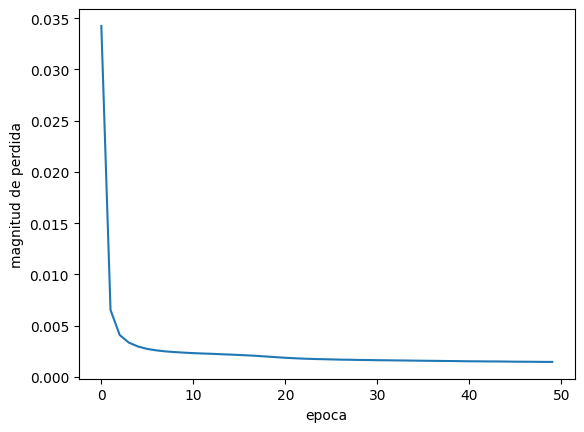

In [8]:
plt.xlabel('epoca')
plt.ylabel('magnitud de perdida')
plt.plot(historial.history["loss"])

In [9]:
y_pred = model.predict(X_temp)


24/24 [==============================] - 0s 870us/step


In [10]:
# Calcular métricas
mae = mean_absolute_error(y_temp, y_pred)
mse = mean_squared_error(y_temp, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_temp, y_pred)

# Mostrar métricas
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")


MAE: 0.022692360736875333
MSE: 0.002462540346504415
RMSE: 0.0496239896270384
R^2: 0.28917051922126197


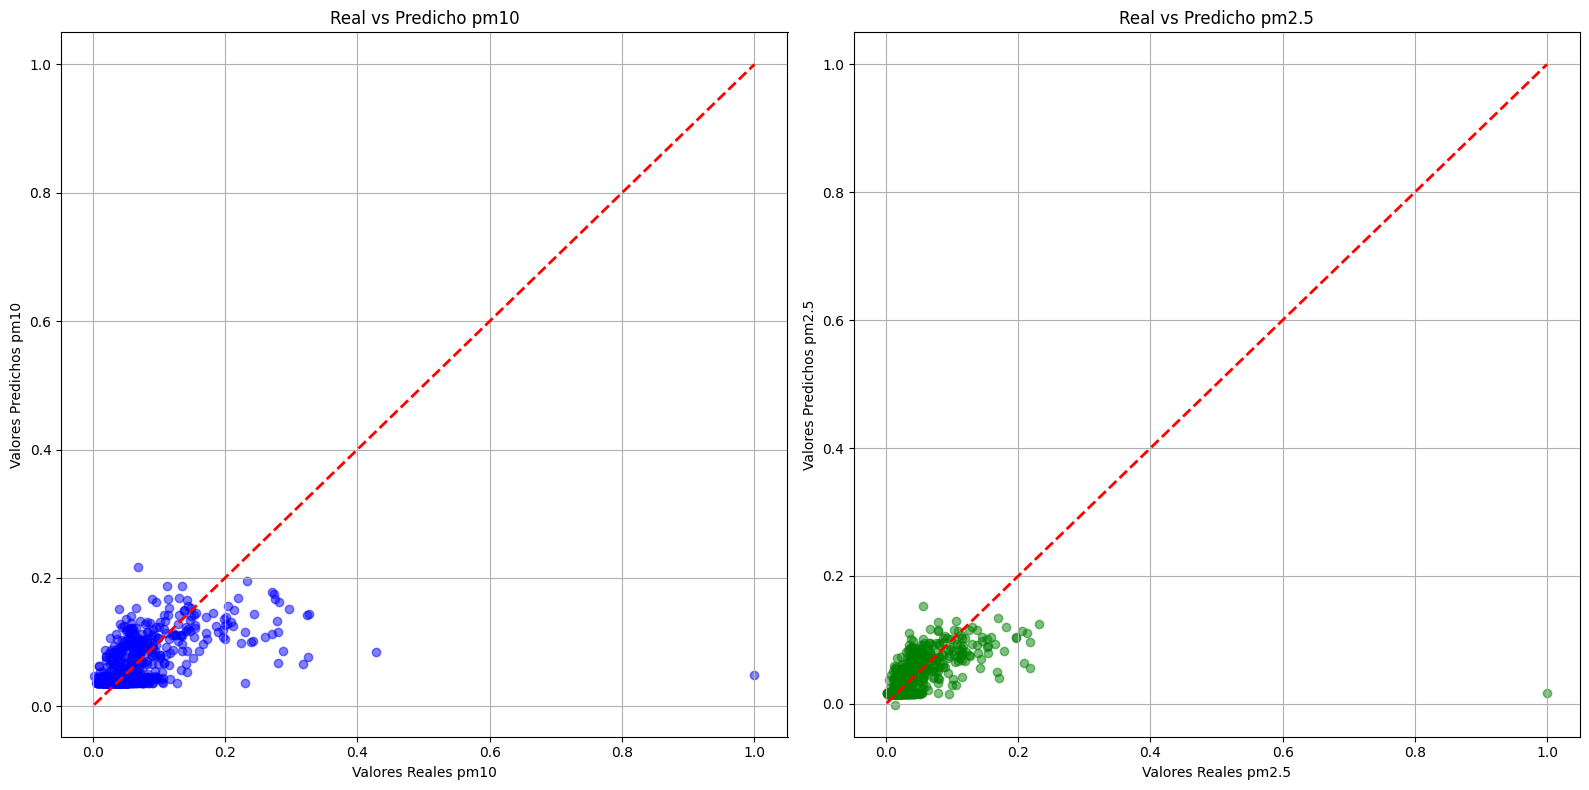

In [11]:
y_true_pm10 = y_temp['pm10']
y_true_pm25 = y_temp['pm2.5']

y_pred_pm10 = y_pred[:, 0]
y_pred_pm25 = y_pred[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(16, 8))  # 1 fila, 2 columnas de gráficos

# grafico para pm10
axs[0].scatter(y_true_pm10, y_pred_pm10, alpha=0.5, color='blue')
axs[0].plot([min(y_true_pm10), max(y_true_pm10)], 
           [min(y_true_pm10), max(y_true_pm10)], 
           color='red', linestyle='--', lw=2)
axs[0].set_title('Real vs Predicho pm10')
axs[0].set_xlabel('Valores Reales pm10')
axs[0].set_ylabel('Valores Predichos pm10')
axs[0].grid(True)





# grafico para pm2.5
axs[1].scatter(y_true_pm25, y_pred_pm25, alpha=0.5, color='green')
axs[1].plot([min(y_true_pm25), max(y_true_pm25)], 
           [min(y_true_pm25), max(y_true_pm25)], 
           color='red', linestyle='--', lw=2)
axs[1].set_title('Real vs Predicho pm2.5')
axs[1].set_xlabel('Valores Reales pm2.5')
axs[1].set_ylabel('Valores Predichos pm2.5')
axs[1].grid(True)

# Ajustar el espacio entre los gráficos
plt.tight_layout()
plt.show()